## Determing the Breed of a Dog in an Image Using Machine Learning

In this notebook, we are going to use transfer learning for deep learning and neural networks to help us identify different breeds of dogs. The data for this project comes from Kaggle's *Dog Breed Identification* competition. This data consists of over 10,000 images of dogs from 120 different breeds.

Since we are using images, this is an unstructured data type problem. The problem type is also a mutli-class image classification, as we are trying to identify multiple (120) breeds of dogs. The main tool we will be using in this project is the machine learning library TensorFlow. The ultimate goal is to build a computer vision model that minimize loss (penalty for bad predictions), while maximizing the accuracy.

### Getting the Workspace Ready and Accessing Data

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.12.0
Hub version: 0.13.0


In [ ]:
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Colab Data/dog-breed-identification/labels.csv")
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

From the above outputs, we can see that there are 10222 different IDs, which means that there are those many distinct images in the data. Let's see how many images there are of each breed.

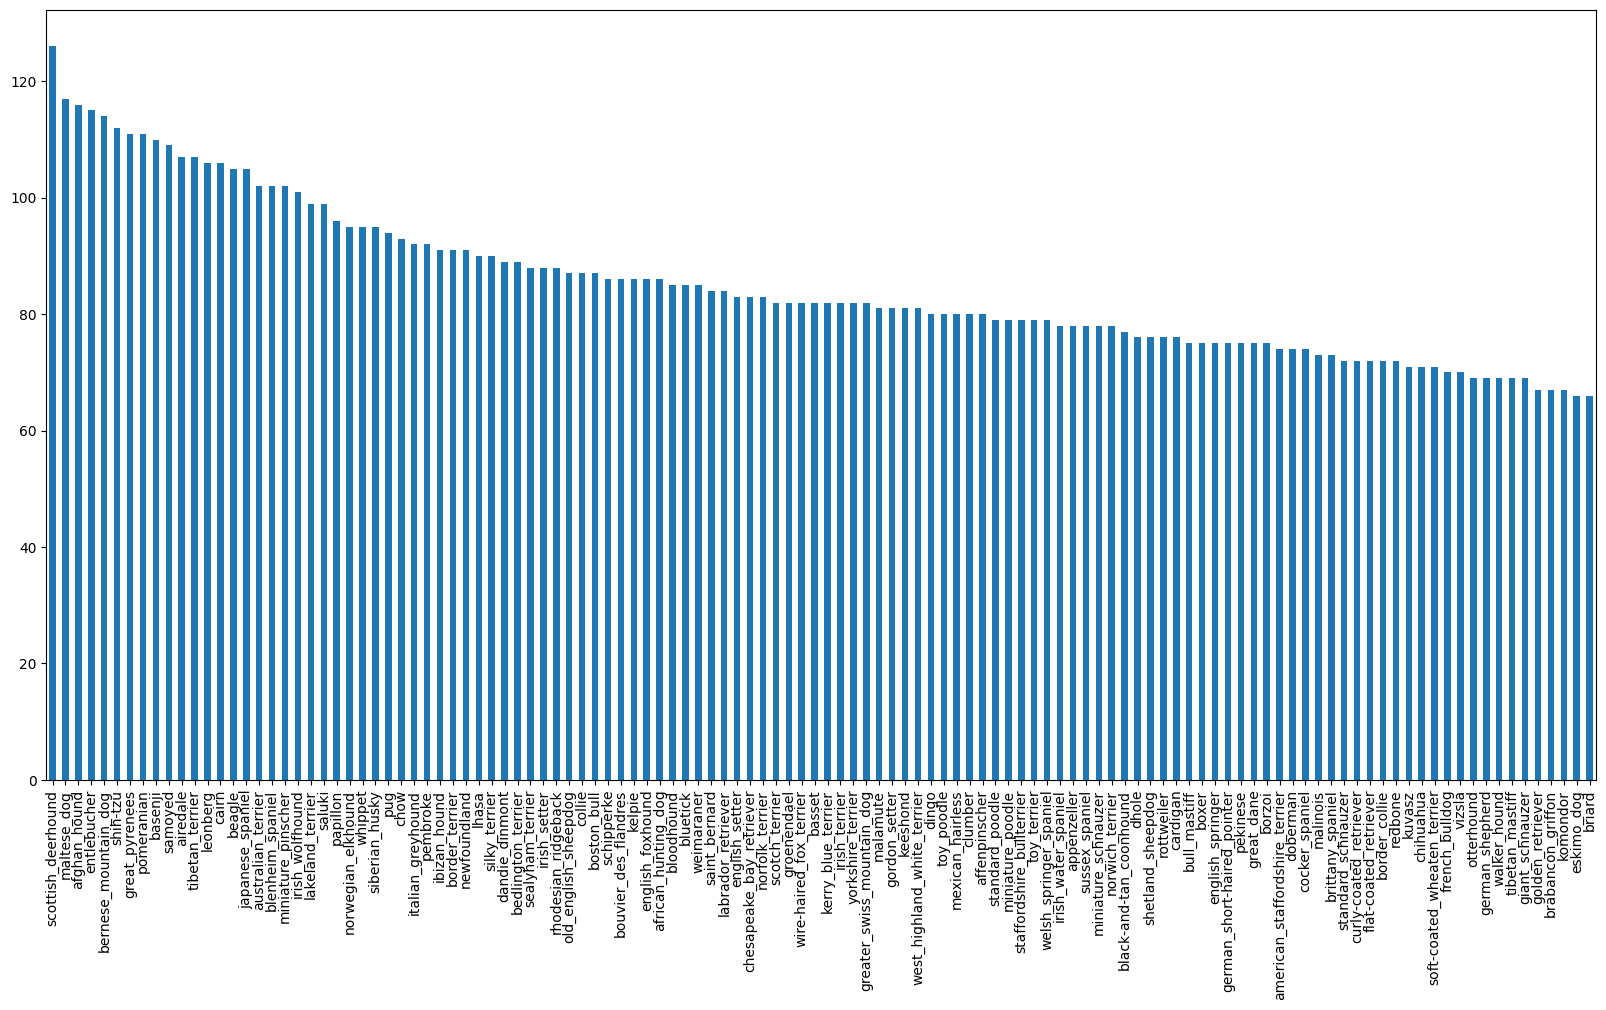

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize = (20, 10));

In [ ]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

For every breed there seems to be at least 60 distinct images, with a few even surpassing 100. The average number of images for each breed is around 85. This should work well for us as for these type of problems, it is suggested that each label have at least 10 images, with around a 100 being a desirable amount. We are not too far off from that number.

### Data Transformation

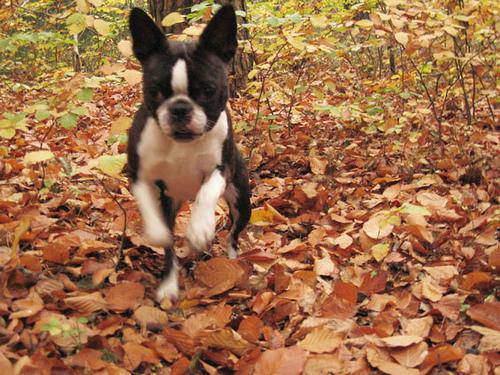

In [ ]:
# Viewing an image
from IPython.display import display, Image
Image("drive/MyDrive/Colab Data/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

We have access to the image IDs and their respective labels, so let's now create a list of the filepaths to all the training images to help access them in a better way.

In [ ]:
# path names for IDs
filenames = ["drive/MyDrive/Colab Data/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]
print(len(filenames))
filenames[:5]

10222


['drive/MyDrive/Colab Data/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab Data/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab Data/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab Data/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab Data/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

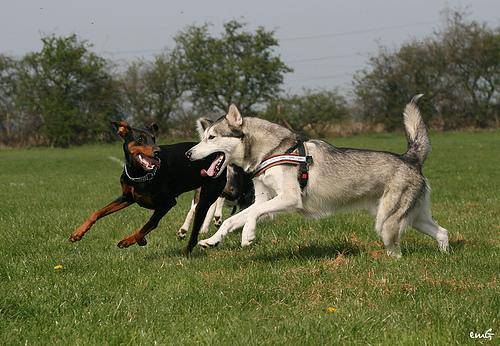

In [ ]:
# Let's check another image directly from the file path
Image(filenames[6581])

Seems like there are two different dogs in this image! Now that we have the filepaths sorted out, let's create an array of all our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels[:5]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever'],
      dtype=object)

In [ ]:
# Checking if number of labels match the number of filenames
len(labels) == len(filenames)

True

We will also have to convert the labels into numbers since whatever deep learning model we choose will not be able to take strings as inputs. To start, all the unique dog breed names need to be found.

In [ ]:
different_breeds = np.unique(labels)
len(different_breeds)

120

As mentioned earlier, the number of different dog breeds is 120. This is consistent with the output above.

In [ ]:
# Turning every label into a boolean array from using unique breeds
boolean_labels = [label == np.array(different_breeds) for label in labels]
boolean_labels[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

This shows the boolean array for the very first label. There is 1 True value and 119 False values, showing that the label is True for one single breed and False for the others. The output only shows it for the first label, but it has been replicated for the whole list. As a result, we have transformed a single dog breed into a one-hot array. These boolean values will be translated into 0 for False and 1 for True when we model.

In the data, we were only given training and validation sets. For this problem, it would be beneficial to validate the model before applying it on the test set. As a result, the training data should be split into both training and validation sets.

In [ ]:
# Setting up X and y variables
X = filenames
y = boolean_labels

Since we're working with over 10,000 images, it is also a good idea to work with just a portion of them initially to reduce time between experiments. Let's go with 1000 images initially, however, we'll create a slider so this value can be easily changed in the future.

In [ ]:
# Setting number of images for experimentation
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Split data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size = 0.2, random_state = 66)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

The labels are in numeric format, but the images are still only file paths. We need to get our images in the form of tensors. Let's write a function that allows us to preprocess our images when we need them.

In [ ]:
# Standardize image size
IMG_SIZE = 224

# Turning image file path into a tensor
def process_image(image_path):
  image = tf.io.read_file(image_path) # read an image file
  image = tf.image.decode_jpeg(image, channels=3) # turn jpeg image into numerical tensor with 3 color channels
  image = tf.image.convert_image_dtype(image, tf.float32) # covert channel range from 0-255 to 0-1
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE]) # resize our image to standardized size
  return image


### Creating Data Batches

In deep learning, rather than finding patterns for an entire dataset at one time, data is usually segreted into mini-batches. This helps TensorFlow become more efficient when computing and saves memory and generally allows a more stable gradient descent. A popular mini-batch size is 32.

In [ ]:
# Create fucntion that returns a tuple of (image, label)
def image_and_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [ ]:
# Let's check if the above code works with an example
image_and_label(X[99], y[99])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.07337623, 0.10474879, 0.18710174],
         [0.02352175, 0.05232077, 0.12723981],
         [0.05393361, 0.08097099, 0.15548079],
         ...,
         [0.03012298, 0.04726562, 0.03929993],
         [0.03193929, 0.0538625 , 0.06219696],
         [0.02757353, 0.05490196, 0.06666667]],
 
        [[0.21297926, 0.25623906, 0.34275866],
         [0.064382  , 0.10764181, 0.18771665],
         [0.14813223, 0.17987242, 0.26234794],
         ...,
         [0.03021167, 0.05919118, 0.03106729],
         [0.03913034, 0.05810571, 0.04392295],
         [0.03933824, 0.05477942, 0.05051865]],
 
        [[0.07015932, 0.1228554 , 0.22261031],
         [0.2152924 , 0.26798847, 0.3677434 ],
         [0.28706342, 0.3330193 , 0.43056834],
         ...,
         [0.0122549 , 0.06213236, 0.02291667],
         [0.03409389, 0.05148806, 0.0257353 ],
         [0.04313726, 0.04816177, 0.02883069]],
 
        ...,
 
        [[0.23600098, 0.21308431

In [ ]:
# Setting batch size
BATCH_SIZE = 32

# function that gets data into batches for test, valid, train
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):

  # With test data we do not have labels so no y values
  if test_data:
    print("Creating batches of test data...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # Validation data
  elif valid_data:
    print("Creating batches of validation data...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data_batch = data.map(image_and_label).batch(BATCH_SIZE)
    return data_batch

    # Training dataset- needs to be shuffled
  else:
    print("Creating batches of training data...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data = data.shuffle(buffer_size=len(x))
    data_batch = data.map(image_and_label).batch(BATCH_SIZE)
    return data_batch

In [ ]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
validation_data = create_data_batches(X_val, y_val, valid_data=True)

Creating batches of training data...
Creating batches of validation data...


In [ ]:
# View the different elements of the data batches
train_data.element_spec, validation_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

Let's visualize this data to help us understand it better.

In [ ]:
import matplotlib.pyplot as plt
# Create a function for viewing images in a data batch
def show_32_images(images, labels):

  plt.figure(figsize = (12, 12))
  for i in range(32):
    ax = plt.subplot(6, 6, i+1)
    plt.imshow(images[i])
    plt.title(different_breeds[labels[i].argmax()])
    plt.axis('off')

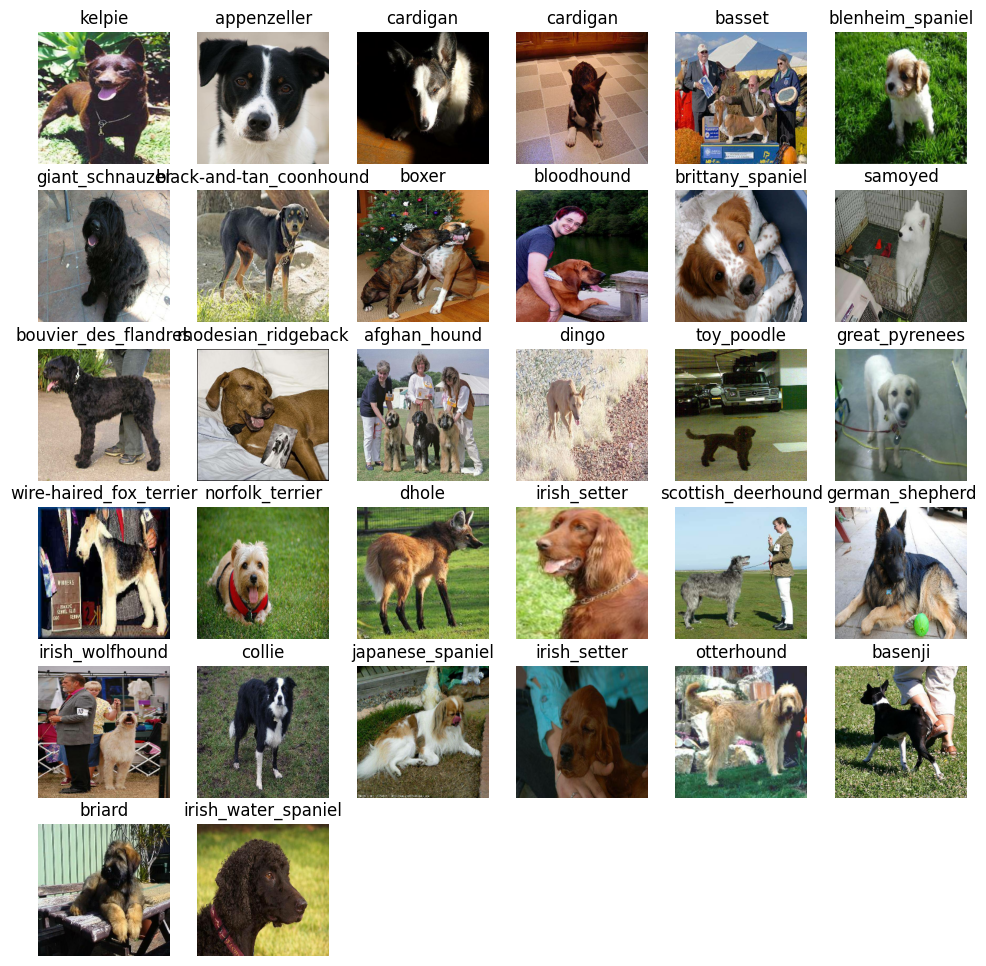

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_32_images(train_images, train_labels)

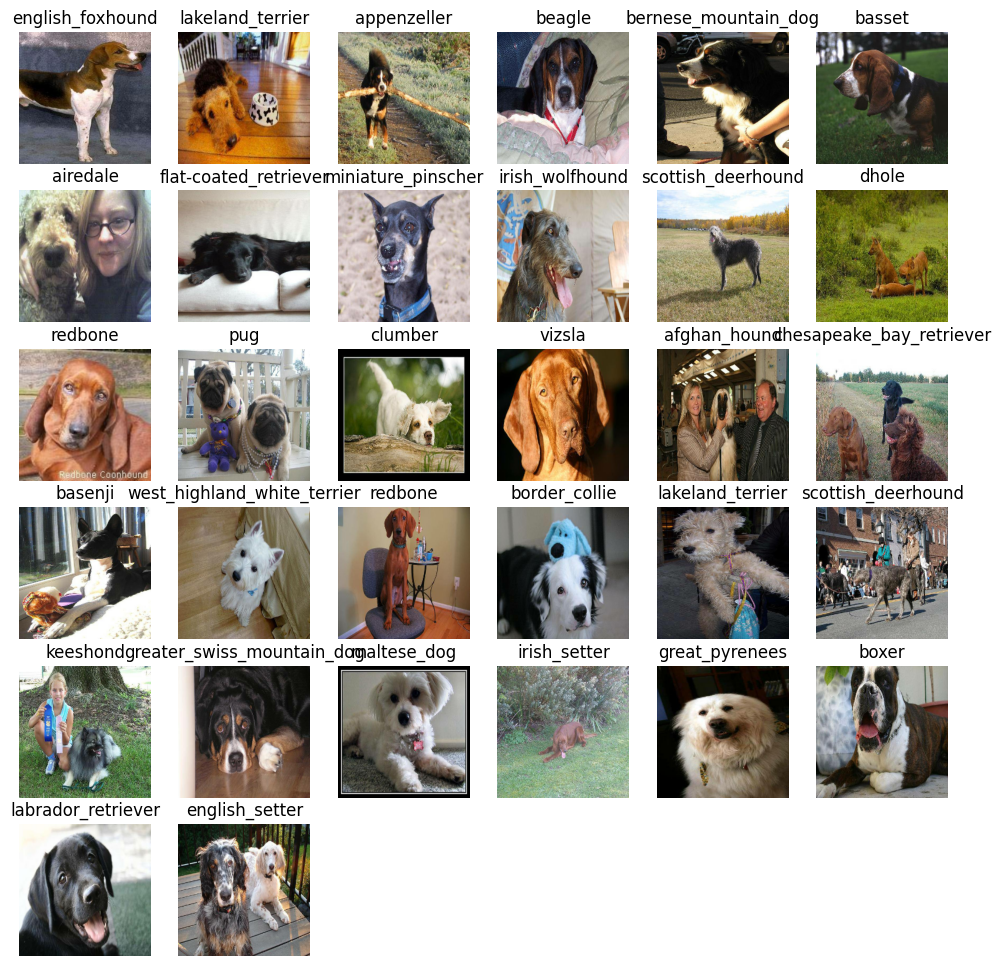

In [ ]:
# Visualize the validation data batch
val_images, val_labels = next(validation_data.as_numpy_iterator())
show_32_images(val_images, val_labels)

### Modelling

In [ ]:
# Setting input shape for model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channel

# Setting ouput shape for model
OUTPUT_SHAPE = len(different_breeds)

# Setting model URL from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5"

Let us now create a function that takes the input and output shapes, the chosen model, defines the model in a sequential fashion, and compiles, builds and returns the model. We will be using the Keras API on top of TensorFlow.

In [ ]:
# Creating function that asssembles keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building Model With:", MODEL_URL)

  # Setting model layers
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL),
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax")])
  # Compiling model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  # Building model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building Model With: https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 3,660,505
Trainable params: 120,240
Non-trainable params: 3,540,265
_________________________________________________________________


We have a model ready to use but before is it trained, a good idea is to generate some callbacks.

In [ ]:
# TensorBoard Callback to check model progress
%load_ext tensorboard
import datetime
import os
# Function to generate tensorboard callback
def tb_callback():
  log_dir = os.path.join("drive/MyDrive/Colab Data/dog-breed-identification/logs",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log_dir)

In [ ]:
# Early Stopping Callback to prevent overfitting
# Stops training when an evaluation metric stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [ ]:
# How many rounds the model goes over the data
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Function to create and return trained model
def train_model():
  model = create_model()

  # Get new tensorboard session each time model is trained
  tensorboard = tb_callback()

  # Fit model
  model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=validation_data,
            validation_freq=1, callbacks=[tensorboard, early_stopping])

  return model

In [ ]:
# Calling function
model = train_model()

Building Model With: https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5
Epoch 1/100
25/25 [==============================] - 113s 4s/step - loss: 4.3871 - accuracy: 0.1163 - val_loss: 3.3156 - val_accuracy: 0.2700
Epoch 2/100
25/25 [==============================] - 4s 162ms/step - loss: 1.4116 - accuracy: 0.7212 - val_loss: 2.1171 - val_accuracy: 0.4500
Epoch 3/100
25/25 [==============================] - 3s 112ms/step - loss: 0.4561 - accuracy: 0.9575 - val_loss: 1.7058 - val_accuracy: 0.5300
Epoch 4/100
25/25 [==============================] - 3s 112ms/step - loss: 0.2064 - accuracy: 0.9950 - val_loss: 1.5602 - val_accuracy: 0.5750
Epoch 5/100
25/25 [==============================] - 3s 116ms/step - loss: 0.1205 - accuracy: 0.9987 - val_loss: 1.5143 - val_accuracy: 0.5900
Epoch 6/100
25/25 [==============================] - 3s 116ms/step - loss: 0.0837 - accuracy: 1.0000 - val_loss: 1.4735 - val_accuracy: 0.6000
Epoch 7/100
25/25 [==============================]

From the above output, we can see the the model is overfitting as it is performing significantly better on the training data compared to the validation data- in terms of both loss and accuracy. Let's remember this model was only trained on 1000 images out of 10,000+, so if we were to increase the number of images we would likely see better results.

In [ ]:
%tensorboard --logdir drive/MyDrive/Colab\ Data/dog-breed-identification/logs

### Making and Evaluating Predictions

Before we try to improve our model by scaling it up, let's get some more looks at how our model performs on the validation set.

In [ ]:
predictions = model.predict(validation_data, verbose=1)
predictions

7/7 [==============================] - 12s 120ms/step


array([[1.0390660e-04, 2.9190141e-04, 2.8357358e-04, ..., 5.3519494e-04,
        4.6515949e-03, 1.0602992e-03],
       [9.4371120e-04, 1.5427046e-04, 3.3899196e-05, ..., 4.8815145e-04,
        1.8739170e-01, 2.0281700e-03],
       [7.9013157e-04, 3.0034650e-04, 1.2314135e-04, ..., 6.2388332e-05,
        6.1831262e-04, 1.1099370e-05],
       ...,
       [1.6372578e-04, 3.2416917e-04, 4.1781558e-04, ..., 2.1613794e-04,
        1.0386767e-03, 2.9864058e-02],
       [2.8349006e-05, 2.5733791e-06, 2.7232520e-05, ..., 1.9035999e-03,
        7.1811484e-04, 4.2265137e-06],
       [8.3432248e-04, 8.4964972e-04, 1.5515288e-05, ..., 1.1109145e-04,
        8.4621622e-04, 7.1746246e-03]], dtype=float32)

In [ ]:
predictions.shape, len(y_val), len(different_breeds)

((200, 120), 200, 120)

In [ ]:
np.sum(predictions[0])

1.0

The predictions has returned an array of 120 probabilties for each image, depending on dog breed. These probabilties can be can be turned into actual labels to help us retrieve proper insights.

In [ ]:
# random prediction
index = 25
print(f'''Max Value/Highest Probability: {np.max(predictions[index])}''')
print(f'''Index of Max Value: {np.argmax(predictions[index])}''')
print(f'''Predicted Value: {different_breeds[np.argmax(predictions[index])]}''')

Max Value/Highest Probability: 0.3801456093788147
Index of Max Value: 53
Predicted Value: greater_swiss_mountain_dog


In [ ]:
# Function to turn probabilities into their respective labels
def get_pred_label(prediction_probabilities):
  return different_breeds[np.argmax(prediction_probabilities)]

get_pred_label(predictions[25])

'greater_swiss_mountain_dog'

Let's try to replicate this for the entirety of the validation set. But, before we do that, we must unbatch the data and turn it into an iterator to get a list of the predicted validation images and labels.

In [ ]:
# Function to unbatch
def unbatch_data(data):
  images = []
  labels = []

  # loop through batched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(different_breeds[np.argmax(label)])
  return images, labels

val_images, val_labels = unbatch_data(validation_data)
val_images[0], val_labels[0]

(array([[[0.57365197, 0.5305147 , 0.56188726],
         [0.53965604, 0.4965188 , 0.52789134],
         [0.5221971 , 0.47905985, 0.5104324 ],
         ...,
         [0.6767759 , 0.59442294, 0.58265823],
         [0.643054  , 0.5607011 , 0.54893637],
         [0.5772296 , 0.49487668, 0.48311198]],
 
        [[0.51944786, 0.47631064, 0.50768316],
         [0.5418487 , 0.49871147, 0.530084  ],
         [0.5880922 , 0.54495496, 0.5763275 ],
         ...,
         [0.6492998 , 0.56694686, 0.55518216],
         [0.59417075, 0.5118178 , 0.50005305],
         [0.61057955, 0.5282266 , 0.5164619 ]],
 
        [[0.5587262 , 0.51558894, 0.5469615 ],
         [0.50649095, 0.46335366, 0.49472624],
         [0.5589935 , 0.51585627, 0.5472288 ],
         ...,
         [0.5822951 , 0.49994218, 0.48817748],
         [0.69717115, 0.6148182 , 0.6030535 ],
         [0.7828223 , 0.7004693 , 0.68870455]],
 
        ...,
 
        [[0.30739775, 0.32308403, 0.36051413],
         [0.33642298, 0.35210925, 0.38953

We should now create a function that allows us view an image and get the predicted and true labels along with it. This will visualize the data and make better inferences about our model.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, k):
  pred_prob, true_label, image = prediction_probabilities[k], labels[k], images[k]
  pred_label = get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
            color = color)

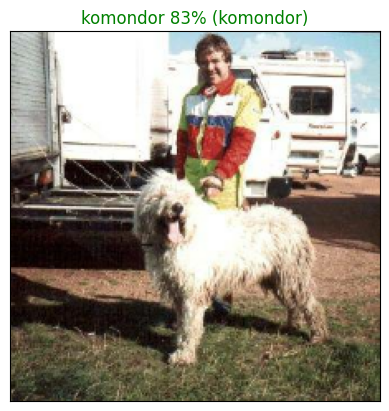

In [ ]:
# Sample plot
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, k=88)

Looks like our model predicted that label correctly and did so with an 83% confidence. It would be helpful to see the top 5 predictions the model made, espcially with labels of a lower probabilty and ones that have been predicted incorrectly.

In [ ]:
def plot_confidence(prediction_probabilities, labels, k):
  pred_prob, true_label = prediction_probabilities[k], labels[k]
  pred_label = get_pred_label(pred_prob)

  top_5_index = pred_prob.argsort()[-5:][::-1]
  top_5_values = pred_prob[top_5_index]
  top_5_labels = different_breeds[top_5_index]

  top_5_plot = plt.bar(np.arange(len(top_5_labels)),
                       top_5_values, color="grey")
  plt.xticks(np.arange(len(top_5_labels)),
             labels=top_5_labels, rotation="vertical")

  if np.isin(true_label, top_5_labels):
    top_5_plot[np.argmax(top_5_labels == true_label)].set_color("green")
  else:
    pass

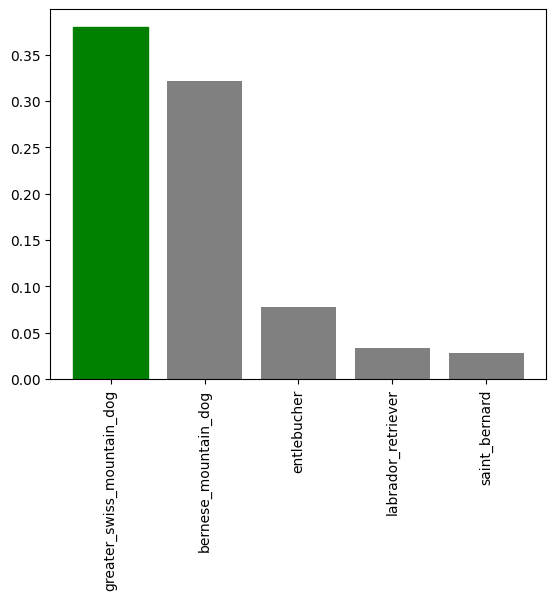

In [ ]:
# Sample plot
plot_confidence(prediction_probabilities=predictions, labels=val_labels, k=25)

### Modelling Part 2 (Full Data)

We have seen our previous model work on a subset of data, so now we can move forward with training a model on the entire dataset in order to improve our results.

In [ ]:
len(X), len(y)

(10222, 10222)

Before we can train a model on all of these 10,222 images, like before, we have to turn them into data batches and call some other functions.

In [ ]:
# Full data into batches
full_data = create_data_batches(X, y)

Creating batches of training data...


In [ ]:
# New model for full data
full_model = create_model()

Building Model With: https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5


In [ ]:
# Full model callbacks

# tensorboard callback
full_model_tb = tb_callback()

# early stopping callback
full_model_es = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

%tensorboard --logdir drive/MyDrive/Colab\ Data/dog-breed-identification/logs

We are ready to fit the full model to the entire training data now.

In [ ]:
full_model.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=[full_model_tb,
                                                          full_model_es])

Epoch 1/100
320/320 [==============================] - 900s 3s/step - loss: 1.2976 - accuracy: 0.6757
Epoch 2/100
320/320 [==============================] - 35s 111ms/step - loss: 0.3795 - accuracy: 0.8885
Epoch 3/100
320/320 [==============================] - 43s 134ms/step - loss: 0.2198 - accuracy: 0.9400
Epoch 4/100
320/320 [==============================] - 40s 126ms/step - loss: 0.1425 - accuracy: 0.9663
Epoch 5/100
320/320 [==============================] - 35s 108ms/step - loss: 0.0963 - accuracy: 0.9809
Epoch 6/100
320/320 [==============================] - 33s 104ms/step - loss: 0.0704 - accuracy: 0.9886
Epoch 7/100
320/320 [==============================] - 32s 100ms/step - loss: 0.0547 - accuracy: 0.9921
Epoch 8/100
320/320 [==============================] - 34s 105ms/step - loss: 0.0440 - accuracy: 0.9943
Epoch 9/100
320/320 [==============================] - 33s 102ms/step - loss: 0.0334 - accuracy: 0.9966
Epoch 10/100
320/320 [==============================] - 33s 104ms/

In [ ]:
def save_model(model, suffix=None):
  '''
  Saves a model in a given directory and appends a suffix for reuse
  '''
  # create model directory
  model_dir = os.path.join("drive/MyDrive/Colab Data/dog-breed-identification/models",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = model_dir + '-' + suffix + ".h5"
  print(f'''Saving Model to: {model_path}...''')
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  '''
  Loads a saved model from a given path
  '''

  print(f'''Loading saved model from: {model_path}''')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Saving full model
save_model(full_model, suffix="full_model_adam")

Saving Model to: drive/MyDrive/Colab Data/dog-breed-identification/models/20230604-13481685886539-full_model_adam.h5...


'drive/MyDrive/Colab Data/dog-breed-identification/models/20230604-13481685886539-full_model_adam.h5'

In [ ]:
# Loading full model
complete_model = load_model("drive/MyDrive/Colab Data/dog-breed-identification/models/20230604-13481685886539-full_model_adam.h5")

Loading saved model from: drive/MyDrive/Colab Data/dog-breed-identification/models/20230604-13481685886539-full_model_adam.h5


### Making Predictions on Test Data

In [ ]:
# Load test image file names
test_path = "drive/MyDrive/Colab Data/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:5]

['drive/MyDrive/Colab Data/dog-breed-identification/test/e917abf625ad6ba5b8a0e59bd23e8818.jpg',
 'drive/MyDrive/Colab Data/dog-breed-identification/test/e91b757847fad1809a9ffa8c15f5504f.jpg',
 'drive/MyDrive/Colab Data/dog-breed-identification/test/e89d149b27db1f144ca122bb29b8ab9f.jpg',
 'drive/MyDrive/Colab Data/dog-breed-identification/test/e924a899e6de9df57c3a95873640f2bd.jpg',
 'drive/MyDrive/Colab Data/dog-breed-identification/test/e8d27c76d6921b27aea1e2da6920396f.jpg']

In [ ]:
len(test_filenames)

10506

The test data set contains 10,506 images. This is slightly more than even our entire training data.

In [ ]:
# generate test data batches
test_data = create_data_batches(test_filenames, test_data=True)

Creating batches of test data...


In [ ]:
# Making predictions on test data batches using the full model
test_predictions = complete_model.predict(test_data, verbose=1)

329/329 [==============================] - 3288s 10s/step


In [ ]:
# Saving predictions as numpy arrays to csv file
np.savetxt("drive/MyDrive/Colab Data/dog-breed-identification/prediction_arrays.csv", test_predictions, delimiter=",")

In [ ]:
# Load the same predictions
test_predictions = np.loadtxt("drive/MyDrive/Colab Data/dog-breed-identification/prediction_arrays.csv", delimiter=",")

Let's now create a DataFrame that contains the model's predicted output probabilities for each label, as well as the image IDs.

In [ ]:
final_preds_df = pd.DataFrame(columns=["id"] + list(different_breeds))
final_preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
# Adding test image IDs
final_preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
final_preds_df.head()

id affenpinscher afghan_hound  \
0  e917abf625ad6ba5b8a0e59bd23e8818           NaN          NaN   
1  e91b757847fad1809a9ffa8c15f5504f           NaN          NaN   
2  e89d149b27db1f144ca122bb29b8ab9f           NaN          NaN   
3  e924a899e6de9df57c3a95873640f2bd           NaN          NaN   
4  e8d27c76d6921b27aea1e2da6920396f           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [ ]:
# Adding prediction probabiltiies for each dog breed column
final_preds_df[list(different_breeds)] = test_predictions
final_preds_df.head()

id  affenpinscher  afghan_hound  \
0  e917abf625ad6ba5b8a0e59bd23e8818   3.664777e-14  9.156143e-13   
1  e91b757847fad1809a9ffa8c15f5504f   7.511721e-12  8.775152e-10   
2  e89d149b27db1f144ca122bb29b8ab9f   5.345714e-11  3.552260e-12   
3  e924a899e6de9df57c3a95873640f2bd   1.233036e-10  6.960298e-08   
4  e8d27c76d6921b27aea1e2da6920396f   3.601940e-10  2.350694e-11   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.202589e-11  3.537750e-10                    9.781273e-15   
1         2.564791e-10  9.535653e-12                    3.397528e-11   
2         5.453569e-12  1.352095e-12                    7.528560e-12   
3         5.546402e-10  3.004883e-09                    4.422043e-11   
4         8.833880e-13  1.155842e-12                    1.951545e-12   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  1.102087e-11        2.111818e-14  2.169573e-15  1.316714e-17  ...   
1  8.152419e-12        4.011365e-09  1.848359e-07  2.096479e-09  ...   
2  1.306693e-10        1.010994e-07  3.658948e-10  1.390452e-11  ...   
3  8.881783e-08        4.697462e-08  1.150023e-07  1.555057e-10  ...   
4  3.714262e-12        7.238489e-08  9.206672e-13  4.109149e-12  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  6.603292e-13  5.433230e-14  1.930901e-16  1.640901e-14  2.700976e-13   
1  1.793997e-09  6.625374e-10  2.701691e-08  1.999054e-10  4.455298e-11   
2  1.003011e-11  3.067446e-10  2.148901e-11  2.455726e-16  6.418486e-13   
3  1.022494e-11  8.355718e-08  3.309456e-11  1.733933e-09  1.973169e-11   
4  1.448672e-13  4.045178e-13  1.319376e-09  2.274930e-12  2.321567e-14   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            6.191448e-12                 1.471101e-15  4.801517e-14   
1            1.811797e-11                 1.373105e-11  1.094480e-08   
2            5.046369e-10                 8.314516e-11  5.190621e-11   
3            2.885743e-08                 3.317824e-11  1.345744e-10   
4            4.809588e-10                 5.477222e-12  6.230556e-13   

   wire-haired_fox_terrier  yorkshire_terrier  
0             1.470202e-17       7.527043e-09  
1             4.419086e-10       2.906009e-12  
2             1.761861e-11       1.386262e-08  
3             6.011843e-06       3.041119e-11  
4             4.133449e-11       9.946270e-12  

[5 rows x 121 columns]

In [ ]:
# Exporting to csv
final_preds_df.to_csv("drive/MyDrive/Colab Data/dog-breed-identification/prediction_submission.csv", index=False)

### Making Predictions on Custom Images

We have trained a model on data and have made predictions on test images, but let's see how the model performs on some custom images. This aspect is one of the main reasons as to why this project was made- to identify different dogs out in the real world. To do this, I have asked a few of my friends to send images of their dogs and accordingly, our model will be used to estimate their respective breeds.

In [ ]:
# Image file paths
ci_path = "drive/MyDrive/Colab Data/dog-breed-identification/Custom Images/"
friends_paths = [ci_path + fname for fname in os.listdir(ci_path)]

In [ ]:
# Turning images into a batch
friends_data = create_data_batches(friends_paths, test_data=True)

Creating batches of test data...


In [ ]:
# Making predictions
friends_preds = complete_model.predict(friends_data)

1/1 [==============================] - 2s 2s/step


In [ ]:
# Prediction labels
friends_pred_labels = [get_pred_label(friends_preds[i]) for i in range(len(friends_preds))]
friends_pred_labels

['siberian_husky',
 'chesapeake_bay_retriever',
 'rottweiler',
 'german_shepherd',
 'chesapeake_bay_retriever']

In [ ]:
friends_images = []
for image in friends_data.unbatch().as_numpy_iterator():
  friends_images.append(image)

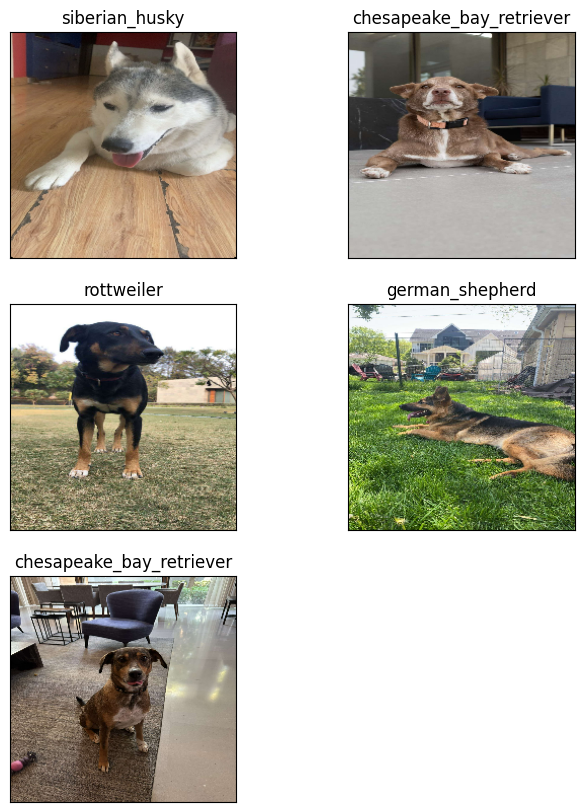

In [ ]:
plt.figure(figsize = (8, 10))
for i, image in enumerate(friends_images):
  plt.subplot(3, 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(friends_pred_labels[i])
  plt.imshow(image)

After consulting my friends about the predictions, it appears that the Siberian Husky and German Shephard estimates were spot on. Moreover, the owners of the three other dogs did not know their respective breeds themselves as they were originally strays, so ultimately, the model has been helpful to them by providings them its calculated guesses.

Overall, this project has been a great learning experience and evidently has utility in the real world. Even besides predicting dog breeds, such technology has a massive scope and has been used in complex problems such as facial recognition and object detection in self-driving cars.